In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import tensorflow as tf
import random
import gc

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, ReLU, BatchNormalization, Dropout
from tensorflow.keras.initializers import HeNormal, Ones, Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
SEED = 3126  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
WIDTH, HEIGHT = 224, 224
BATCH_SIZE = 32
LEARNING_RATE = .001
EPOCHS = 25
DIR = "/kaggle/input/finalized-astrovision-data/denoised (1)/denoised"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.125,
    height_shift_range=0.125,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)
train_generator = train_datagen.flow_from_directory(
    DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

Found 4607 images belonging to 4 classes.
Found 1534 images belonging to 4 classes.


In [4]:
def make_dense_layer(input_size, dropout_rate=0.0, input_shape=None):
    layers = []
    if input_shape:
        layers.append(Dense(input_size,
                            use_bias=False, 
                            input_shape=input_shape,
                            kernel_initializer=HeNormal()
                            ))
    else:
        layers.append(Dense(input_size, use_bias=False, kernel_initializer=HeNormal()))
    layers.extend([BatchNormalization(gamma_initializer=Ones(), beta_initializer=Constant(0.1)),
                  ReLU()])
    if dropout_rate > 0:
        layers.append(Dropout(dropout_rate))
    return Sequential(layers)

In [5]:
def build_model():
    base_model = ResNet152V2(weights="imagenet", include_top=False,
                             input_shape=(WIDTH, HEIGHT, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    fc_layers = Sequential([
        make_dense_layer(1024, input_shape=(x.shape[-1],), dropout_rate=.2),
        make_dense_layer(512, dropout_rate=.2),
        make_dense_layer(8)
    ])
    x = fc_layers(x)
    predictions = Dense(train_generator.num_classes,
                        activation='softmax',
                        kernel_initializer=HeNormal())(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(LEARNING_RATE),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])   
    return model

In [6]:
model = build_model()

best_path = "/kaggle/working/best_weights.weights.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=best_path,  
    monitor='val_loss',    
    save_best_only=True,       
    save_weights_only=True,    
    mode='min',                
    verbose=1                  
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()  
        gc.collect() 

In [8]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, ClearMemory()]
)

model.load_weights(best_path)
initial_test_loss, initial_test_acc = model.evaluate(validation_generator, 
                                                     steps=validation_generator.samples // BATCH_SIZE)

print(f"Test Accuracy Before Fine-tuning: {initial_test_acc*100:.2f}%")

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7031 - loss: 0.7758
Epoch 1: val_loss improved from inf to 0.45387, saving model to /kaggle/working/best_weights.weights.h5
144/144 ━━━━━━━━━━━━━━━━━━━━ 1299s 9s/step - accuracy: 0.7035 - loss: 0.7750 - val_accuracy: 0.8390 - val_loss: 0.4539
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8106 - loss: 0.5196
Epoch 2: val_loss improved from 0.45387 to 0.44888, saving model to /kaggle/working/best_weights.weights.h5
144/144 ━━━━━━━━━━━━━━━━━━━━ 1272s 9s/step - accuracy: 0.8106 - loss: 0.5195 - val_accuracy: 0.8057 - val_loss: 0.4489
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8144 - loss: 0.4535
Epoch 3: val_loss improved from 0.44888 to 0.38230, saving model to /kaggle/working/best_weights.weights.h5
144/144 ━━━━━━━━━━━━━━━━━━━━ 1270s 9s/step - accuracy: 0.8144 - loss: 0.4535 - val_accuracy: 0.8246 - val_loss: 0.3823
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.814

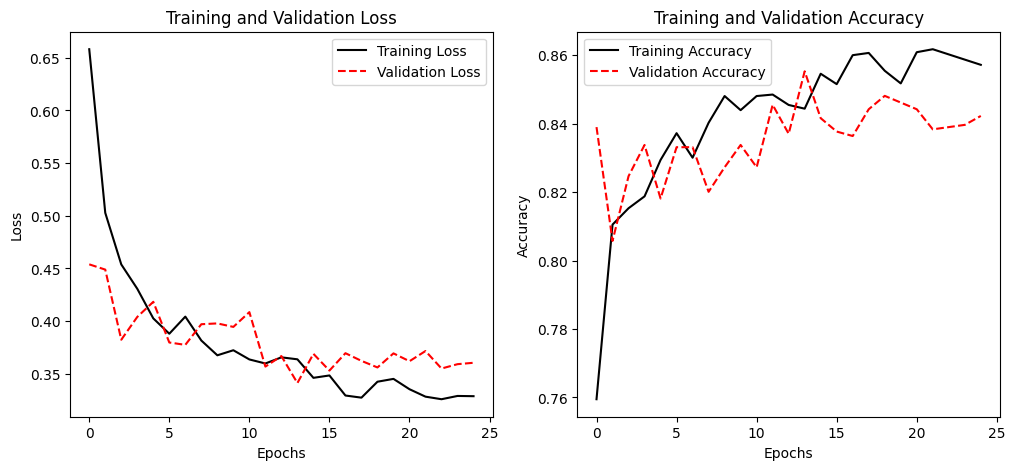

In [9]:
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
epochs_range = range(len(train_loss))

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss', color="black")
plt.plot(epochs_range, val_loss, label='Validation Loss', color="red", linestyle="--")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy', color="black")
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color="red", linestyle="--")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 333s 7s/step


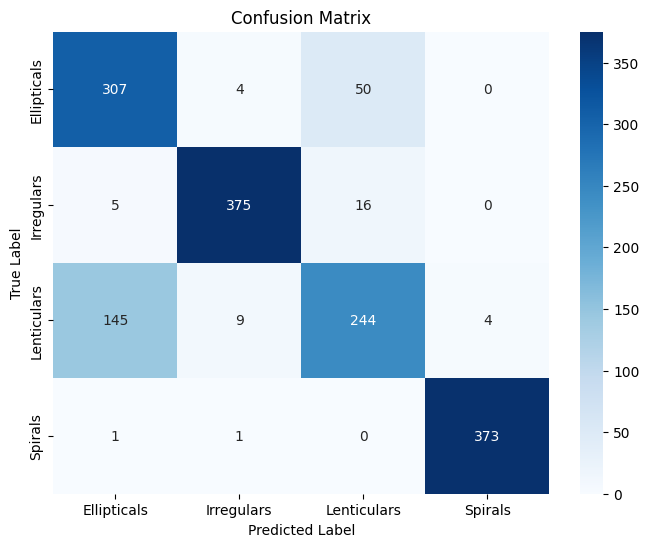

In [10]:
true_labels = validation_generator.classes  # Actual labels from the dataset

pred_probs  = model.predict(validation_generator)  # Probabilities
pred_labels = np.argmax(pred_probs, axis=1)  # Convert softmax to class indices

# Step 3: Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8,6))
sea.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()